# データの準備

In [2]:
!curl -O http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3872k  100 3872k    0     0  1792k      0  0:00:02  0:00:02 --:--:-- 1791k


In [20]:
import numpy as np
import pandas as pd

email_data = pd.read_csv('./Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')

In [23]:
male_data = email_data.copy()
male_data = male_data[male_data['segment'].isin(['Mens E-Mail', 'No E-Mail'])]
male_data['treatment'] = male_data['segment'].apply(lambda x: 1 if x == 'Mens E-Mail' else 0)
male_data['history_log'] = np.log(male_data['history'])

In [69]:
threshold_value = 5.5
rdd_data = male_data.copy()
rdd_data['history_log_grp'] = np.round(rdd_data['history_log'], 1)
rdd_data = (
    rdd_data[
             ((rdd_data['history_log'] > threshold_value) & (rdd_data['segment'] == 'Mens E-Mail'))
             | ((rdd_data['history_log'] <= threshold_value) & (rdd_data['segment'] == 'No E-Mail'))
    ]
)

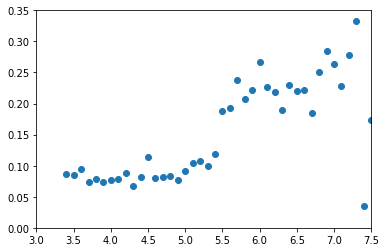

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

plot_data = rdd_data.groupby(['history_log_grp']).agg(visit=('visit' , 'mean'), N=('visit', 'count')).reset_index()

plt.plot(plot_data['history_log_grp'], plot_data['visit'], 'o')
plt.xlim([3, 7.5])
plt.ylim([0, 0.35])
plt.show()

# 集計による分析

In [74]:
rdd_data_table = rdd_data.copy()
rdd_data_table = rdd_data.groupby('treatment').agg(N=('visit', 'count'), visit_rate=('visit' , 'mean')).reset_index()

In [75]:
rdd_data_table

,treatment,N,visit_rate
0,0,13926,0.090694
1,1,7366,0.224002


# 線形回帰による分析

In [78]:
from statsmodels.formula.api import ols

rdd_lm_reg = ols('visit ~ treatment + history_log', data=rdd_data).fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [80]:
rdd_lm_reg.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0404,0.016,2.454,0.014,0.008,0.073
treatment,0.1137,0.008,14.240,0.000,0.098,0.129
history_log,0.0114,0.004,3.103,0.002,0.004,0.019


# 非線形回帰による分析

$$ Y = \beta_0 + \beta_1 f_1(X-c) + \beta_2 f_2(X-c) + \rho Z + \epsilon $$

In [123]:
from sklearn.preprocessing import PolynomialFeatures

nonlinear_rdd_data = rdd_data.copy()[['visit', 'treatment', 'history_log']].reset_index()

cutpoint = 5.5
degree = 4
X = nonlinear_rdd_data[['history_log']]
X = X - cutpoint
X_poly = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X)
X_poly = pd.DataFrame(X_poly, columns=[f'X{i+1}' for i in range(X_poly.shape[1])])

nonlinear_rdd_data = pd.concat([nonlinear_rdd_data, X_poly], axis=1)

In [127]:
nonlinear_rdd_ord4 = ols('visit ~ treatment + X1 + X2 + X3 + X4 + treatment:X1 + treatment:X2 + treatment:X3 + treatment:X4', data=nonlinear_rdd_data).fit()
nonlinear_rdd_ord4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1327,0.014,9.654,0.000,0.106,0.160
treatment,0.0741,0.020,3.774,0.000,0.036,0.113
X1,0.1522,0.092,1.661,0.097,-0.027,0.332
X2,0.1877,0.178,1.056,0.291,-0.161,0.536
X3,0.1068,0.126,0.847,0.397,-0.140,0.354
X4,0.0224,0.029,0.769,0.442,-0.035,0.079
treatment:X1,-0.0406,0.135,-0.300,0.764,-0.306,0.225
treatment:X2,-0.3928,0.271,-1.449,0.147,-0.924,0.139
treatment:X3,0.0278,0.198,0.140,0.888,-0.360,0.415
treatment:X4,-0.0484,0.047,-1.032,0.302,-0.140,0.044


# nonparametric RDD

## 利用するデータの範囲と推定結果

In [214]:
(out_data['visit_rate']**2).sum()

0.05857517467283785

In [219]:
cutpoint = 5.5

bound_list = np.arange(0.02, 1+ 0.02, 0.02)
N_list = list()
late_list = list()
ci_upper = list()
ci_lower = list()
for bound in bound_list:
  out_data = (
      rdd_data[(rdd_data['history_log'] >= cutpoint - bound) & (rdd_data['history_log'] <= cutpoint + bound)]
      .groupby('treatment').agg(count=('treatment', 'count'), visit_rate=('visit', 'mean'), sd=('visit', 'std'))
      .reset_index()
  )
  N = out_data['count'].sum()
  N_list.append(N)
  late = out_data[out_data['treatment'] == 1]['visit_rate'].values[0] - out_data[out_data['treatment'] == 0]['visit_rate'].values[0]
  late_list.append(late)
  std = np.sqrt((out_data['visit_rate']**2).sum())/np.sqrt(N)
  ci_upper.append(late+std)
  ci_lower.append(late-std)
  

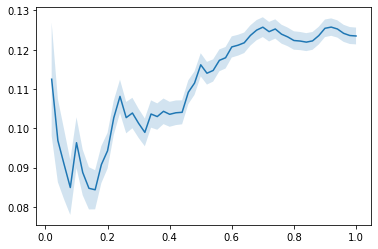

In [222]:
plt.plot(bound_list, late_list)
plt.fill_between(bound_list, ci_lower, ci_upper, alpha=0.2)
plt.show()

## 実装

In [154]:
cutpoint = 5.5
bound = 0.1

bounded_data = rdd_data[(rdd_data['history_log'] >= cutpoint - bound) & (rdd_data['history_log'] <= cutpoint + bound)]
rdd_result = ols('visit ~ treatment + history_log', data=bounded_data).fit()

In [155]:
rdd_result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.2050,1.836,-0.656,0.512,-4.807,2.397
treatment,0.0715,0.040,1.807,0.071,-0.006,0.149
history_log,0.2434,0.337,0.722,0.470,-0.418,0.905
